In [78]:
from pair_trading import *
import statsmodels.tsa.stattools as ts
from tqdm import tqdm
from scipy import stats

# scipy.stats.median_abs_deviation
# import QuantConnect

In [ ]:
# tickers = pd.read_csv('nasdaq.csv')
# tickers 
# tk_ls = tickers.head(500).Symbol.to_list()

In [ ]:
tickers = pd.read_csv('sp_new.csv')
tk_ls = tickers.head(503).Symbol.to_list()

In [ ]:
tickers.shape

In [229]:
raw = yf.download(tk_ls, interval= '1d', start= '2020-12-01', end='2022-12-31', show_errors=True, progress=False)

# # raw = pd.read_csv('stock_raw.csv')
# dt = np.log(raw.loc[:,'Adj Close'])
# dt.to_csv('nasdaq_stock_raw.csv')
# print(dt.shape)
# dt.head()


2 Failed downloads:
- BRK.B: No timezone found, symbol may be delisted
- BF.B: No data found for this date range, symbol may be delisted


In [230]:
col_100 = raw['Adj Close'].columns[raw['Adj Close'].head(100).isna().sum()>0].tolist() + ['BDX']


In [231]:
dt = raw['Adj Close'].drop(col_100, axis = 1).iloc[:-1, :]
dt = dt.drop(dt.columns[dt.isna().sum()>0].tolist(), axis = 1)

In [232]:
dt.isna().sum().sum()

0

In [233]:
dt.columns[dt.isna().sum()>0]

Index([], dtype='object')

In [234]:
# dt.to_csv('nasdaq500_train_202107_202207.csv')

adf_dt = np.log(dt).diff().iloc[1:,]
adf_rst = adf_dt.apply(lambda x: adfuller(x)[0], axis = 0).sort_values()
# adf_rst


In [235]:
ind = adf_rst.loc[adf_rst < -10].index.tolist()

In [236]:
len(ind)

474

In [269]:
# dt.to_csv('sp500_mse_data.csv', index = False)
var = 'AMZN'
tesla = (dt[[var]]).diff()
win = 100
tesla['mad'] = tesla.iloc[:, 0].rolling(window=win).apply(stats.median_abs_deviation)
tesla['mean'] = tesla.iloc[:, 0].rolling(window = win).mean()
tesla['median'] = tesla.iloc[:, 0].rolling(window = win).median()
tesla['stdv'] = tesla.iloc[:, 0].rolling(window = win).std()

tesla['mz_score'] = tesla.apply(lambda x: 0.6745*(x[var] - x['median'])/x['mad'], axis = 1)
tesla['z_score'] = tesla.apply(lambda x: 0.6745*(x[var] - x['mean'])/x['stdv'], axis = 1)


<AxesSubplot: xlabel='Date'>

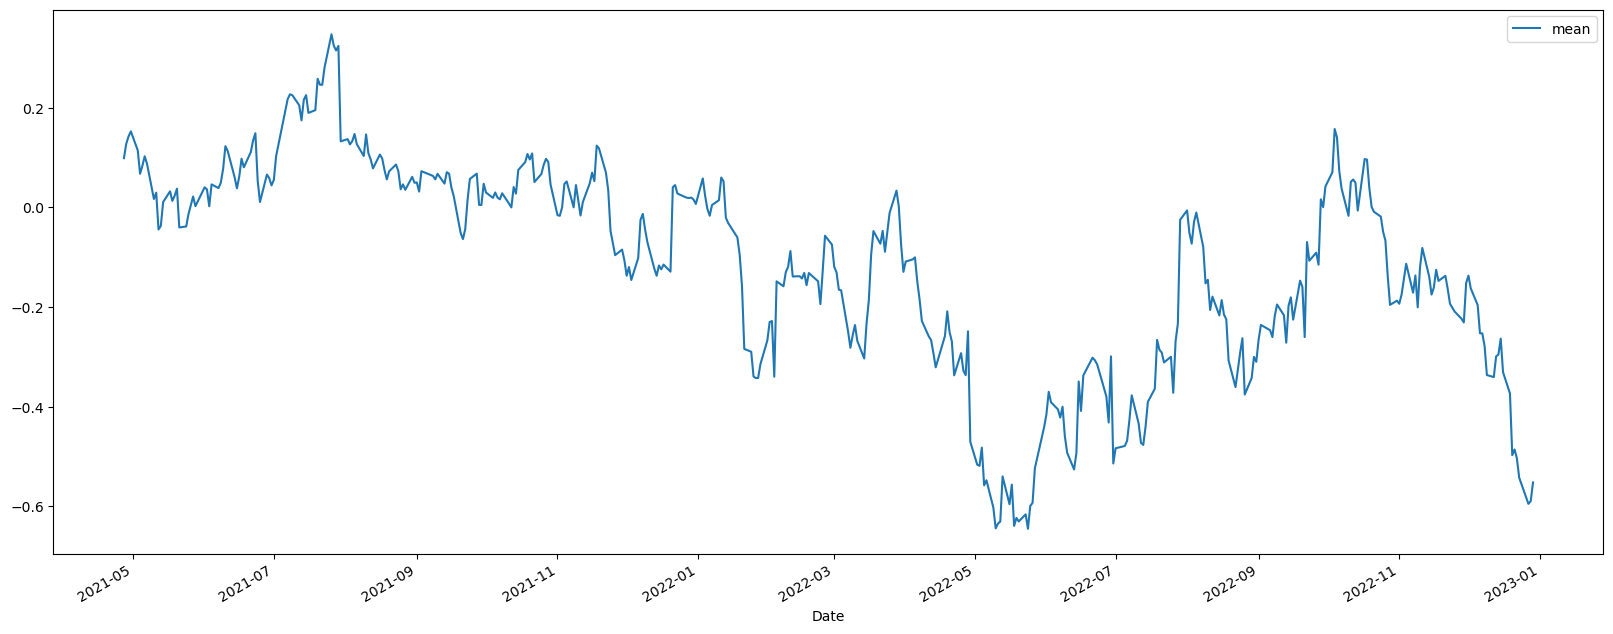

In [271]:
tesla.dropna().loc[:,['mean']].plot(figsize = (20, 8))

# plt.hlines(y=-3.5, colors='red')


In [ ]:
# m = adf_rst.shape[0]
# fdr = 0.01
# max([(x[0] + 1) if x[1]< fdr*(x[0] + 1)/m else 0 for x in enumerate(adf_rst.to_list())])
# # [adf_rst.to_list()]

In [ ]:
train = dt.loc[:, ind]/dt.loc[:,ind].iloc[0, :]
# train.head()

In [ ]:
%%time 
rst = {}
for n in tqdm(train.columns):
    x = train - train.loc[:, [n]].values
    if n not in rst:
        rst[n] = x.apply(lambda x: np.square(x).mean(), axis = 0).sort_values().head(11).to_dict()
        
    else:
        print(n)
    # break
# r = find_pairs(dt)
# r

In [ ]:
rs_ls = []
for k in rst.items():
    for in_k in k[1].items():
        if k[0] == in_k[0]:
            continue
        elif (in_k[0], k[0]) in rs_ls:
            continue
        else:
            rs_ls.append((k[0], in_k[0]))

In [ ]:
candidates = sorted(rs_ls, key = lambda x: x[-1], reverse=False)
len(candidates)
# candidates

In [70]:

# dt = raw
dt = yf.download(train.columns.tolist(), interval= '1d', start= '2020-12-01', end='2022-12-01', show_errors=True, progress=True)

[*********************100%***********************]  441 of 441 completed


In [71]:

def test_two_pairs(x_1, x_2):

    X = x_1
    X = sm.add_constant(X)
    model = 1#sm.OLS(x_2, X)
    lm_rst = (1,1)#model.fit()
    # result = adfuller(lm_rst.resid.values, regression = 'n')
    result = ts.coint(x_1, x_2)
    return result[1], lm_rst, result[0]


thrd = 0.001
ls = []
for cand_stock in tqdm(candidates):
    a, b= cand_stock
    # dt = yf.download([a, b], interval= '1h', start= '2022-05-01', end='2022-11-01', show_errors=True, progress=False)
    if dt['Adj Close'].loc[:, [a, b]].isna().mean().max() <= 0.03:
        dt_new = dt['Adj Close'].loc[:, [a, b]].dropna()
    else:
        # print(dt['Adj Close'].loc[:, [a, b]].isna().mean())
        continue
    # dt_new = np.log(dt_new)
    x1 = np.log(dt_new.iloc[:, 0])
    x2 = np.log(dt_new.iloc[:, 1])
    try:
        p, lm, t = test_two_pairs(x1, x2)
        # if lm.params[-1] > 0:
        ls.append((a, b, p, t))
            
            
    except:
        print(dt_new.head(1))
        continue

    # break

100%|██████████| 3125/3125 [00:28<00:00, 109.08it/s]


In [48]:
def show_pairs(x1, x2, start= '2020-01-01', end= '2022-06-01', intv = '1h', plotting = False):
    raw = yf.download([x1, x2], interval= intv, start=start, show_errors=False).dropna()

    dt = raw.loc[start:end,:]
    # print(dt.tail(3))
    test_dt = raw.loc[end:,:]
    X = np.log(dt.loc[:,'Adj Close'].iloc[:, 0])
    # X = dt.loc[:,'Adj Close'].iloc[:, 0]
    X = sm.add_constant(X)
    model = sm.OLS(np.log(dt.loc[:,'Adj Close'].iloc[:, 1]), X)
    # model = sm.OLS((dt.loc[:,'Adj Close'].iloc[:, 1]), X)
    rst = model.fit()
    # print(rst.summary())
    
    params = rst.params

    test_X = np.log(test_dt.loc[:,'Adj Close'].iloc[:, 0])
    # test_X = (test_dt.loc[:,'Adj Close'].iloc[:, 0])

    test_X = sm.add_constant(test_X)
    test_rst = np.log(test_dt.loc[:,'Adj Close'].iloc[:, 1])- rst.predict(test_X)
    # test_rst = (test_dt.loc[:,'Adj Close'].iloc[:, 1])- rst.predict(test_X)

    if plotting:
        print(dt.Close.tail(3))
        temp_dt = (raw.loc[:,'Adj Close'])#/raw.loc[:,'Adj Close'].iloc[0])
        # temp_dt.plot(figsize = (19, 7))
        # plt.show()
        # diff = (temp_dt.iloc[:, 0] - (temp_dt.mean()[0]/temp_dt.mean()[1])*temp_dt.iloc[:, 1])
        # diff.plot(figsize = (19, 7))
        # plt.hlines(y=diff.mean(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        # plt.hlines(y = diff.mean()-2* diff.std(), colors='red',xmin = diff.index.min(), xmax = diff.index.max())
        # plt.hlines(y = diff.mean()+ 2* diff.std(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        # (dt.Close).plot(figsize = (19, 12))
        plt.show()
        print(rst.summary())
        diff = ((1/(1 + rst.params[-1]))*temp_dt.iloc[:, 1] - (rst.params[-1]/(1 + rst.params[-1]))*temp_dt.iloc[:, 0])
        diff.plot(figsize = (19, 7))
        plt.hlines(y=diff.mean(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()-2* diff.std(), colors='red',xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()+ 2* diff.std(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.show()
        diff = (np.log(temp_dt.iloc[:, 1]) - (rst.params[-1])*np.log(temp_dt.iloc[:, 0]))
        diff.plot(figsize = (19, 7))
        plt.hlines(y=diff.mean(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()-2* diff.std(), colors='red',xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()+ 2* diff.std(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()-3* diff.std(), colors='red',xmin = diff.index.min(), xmax = diff.index.max())
        plt.hlines(y = diff.mean()+ 3* diff.std(), colors='red', xmin = diff.index.min(), xmax = diff.index.max())
        plt.show()
        return rst, dt, test_X, test_rst
    else:
        return rst
    
def adf_rst(rst):
    result = adfuller(rst, regression='n')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    return result[1]

In [49]:
# sec_ls = []

# for k, v in r.items():
#     x1 = k
#     for v_2 in v:
#         try:
#             x2 = v_2[0]
#             rst = show_pairs(x1, x2)
#             p = adf_rst(rst.resid.values)
#             if p < 0.01:
#                 sec_ls.append((k, x2, p))
#         except:
#             continue
#     # break

In [72]:
def BH_test(ls, q = 0.05):
    sorted_ls = sorted(ls, key = lambda x: x[-1], reverse=False)
    m = len(ls)
    lab_ls = [(x[0] + 1) if x[1][2]< q*(x[0] + 1)/m else 0 for x in enumerate(sorted_ls) ]
    try:
        max_num = max(lab_ls)
        print(max_num)
    except:
        return []
    return sorted_ls[:max_num]
    

In [73]:
print(len(ls))
BH_test(ls, q=0.05)
# len(ls)

3115
4


[('HWM', 'KMI', 6.396487571031714e-06, -5.718866101360674),
 ('PHM', 'PPG', 1.905950267429673e-05, -5.486676008372078),
 ('NTAP', 'DOV', 1.9433951000437462e-05, -5.482462161234363),
 ('WY', 'CHD', 4.6814898521403036e-05, -5.28892650511477)]

[*********************100%***********************]  2 of 2 completed
                  CHD         WY
Date                            
2022-11-29  79.489998  31.760000
2022-11-30  81.870003  32.709999
2022-12-01  82.239998  32.279999
                            OLS Regression Results                            
Dep. Variable:                     WY   R-squared:                       0.657
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     119.0
Date:                Wed, 11 Jan 2023   Prob (F-statistic):           4.65e-16
Time:                        21:59:02   Log-Likelihood:                 127.47
No. Observations:                  64   AIC:                            -250.9
Df Residuals:                      62   BIC:                            -246.6
Df Model:                           1                                         
Covariance Type:            nonrobust                  

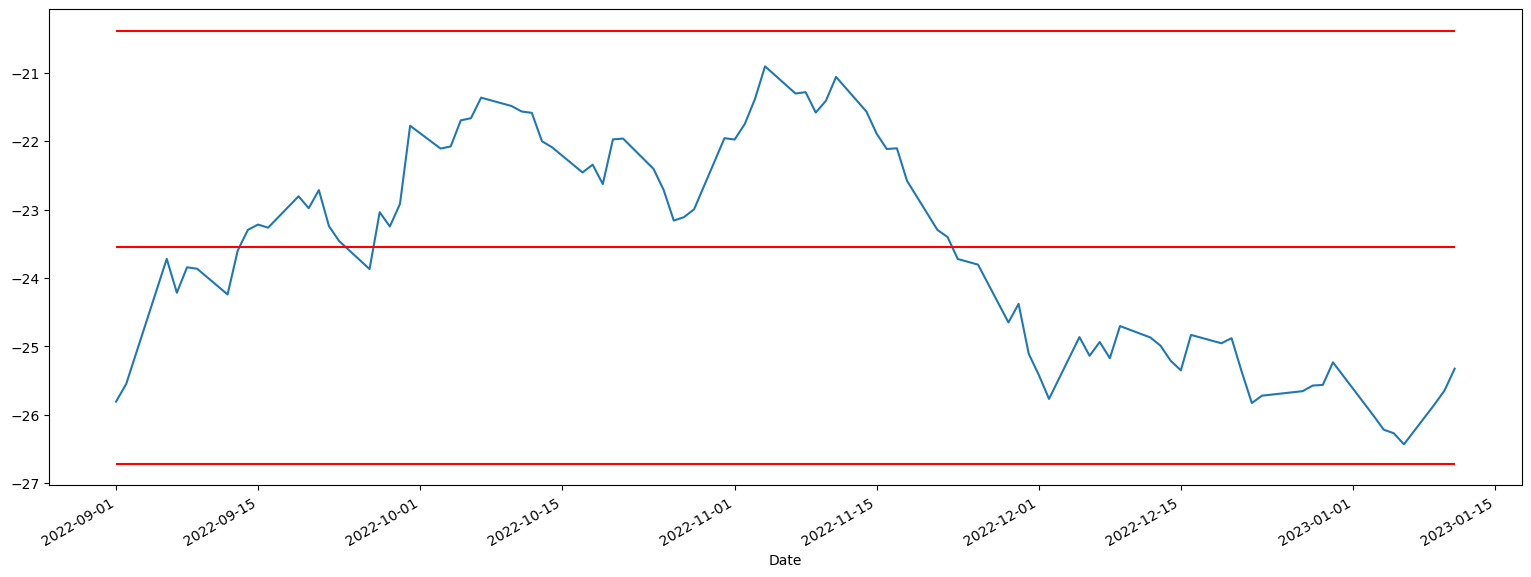

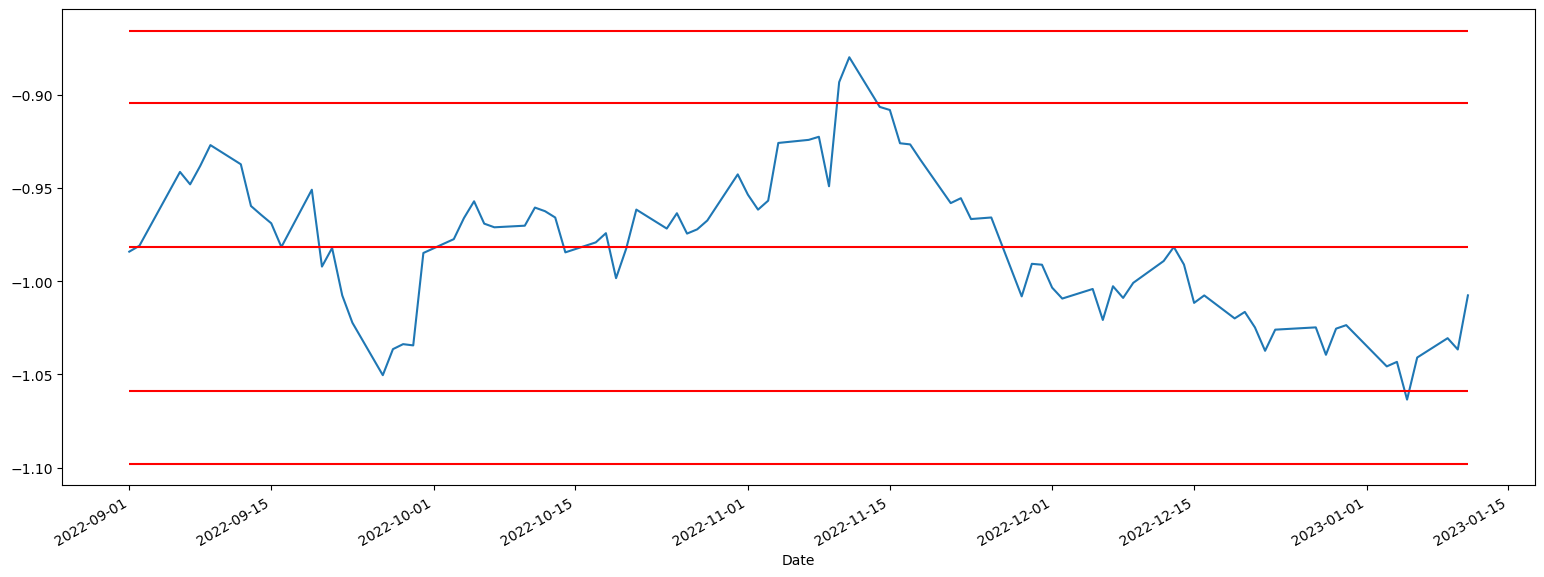

ADF Statistic: -2.207852
p-value: 0.026185


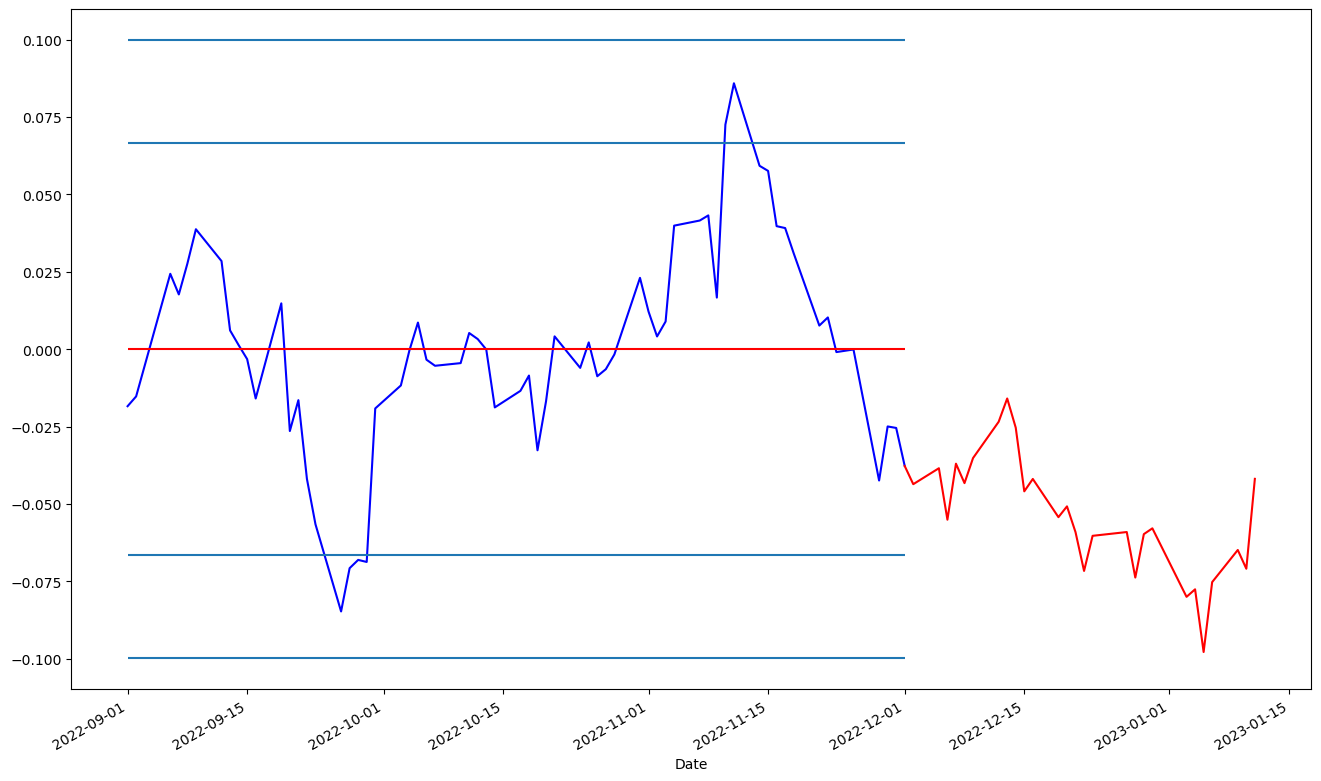

<AxesSubplot: >

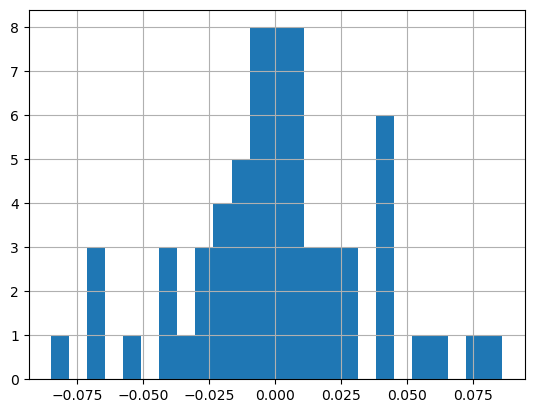

In [77]:
x1, x2 = 'WY', 'CHD'

rst, dt, test_X, test_rst = show_pairs(x1=x1, x2=x2,start= '2022-09-01', end= '2022-12-01', plotting=True, intv='1d')
adf_rst(rst.resid.values)
from turtle import color


plt.figure(figsize=(16, 10))
(rst.resid).plot(color= 'blue')
plt.plot(test_rst,color = 'red')
plt.hlines(y=0, colors='red', xmin=min(dt.index), xmax=max(dt.index))
plt.hlines(y=2*rst.resid.std(), xmin=min(dt.index), xmax=max(dt.index))
plt.hlines(y=-2*rst.resid.std(), xmin=min(dt.index), xmax=max(dt.index))
plt.hlines(y=3*rst.resid.std(), xmin=min(dt.index), xmax=max(dt.index))
plt.hlines(y=-3*rst.resid.std(), xmin=min(dt.index), xmax=max(dt.index))
plt.show()
rst.resid.hist(bins = 25)